Congratulations on reaching the assignment stage!

On this assignment you will work with a dataset of real life taxi rides and will prepare a basic prediction model, just like we do at Autofleet.

Instructions will be provided as you progress through this notebook.

Please try to be as detailed and descriptive as possible so that we understand your
thought process.

In [1]:
%matplotlib inline
import pandas as pd

## Load Data

In [2]:
df_rides = pd.read_csv('rides.csv')
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


## Data Exploration

In [3]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'rides'})
df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()


,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


### Task #1

Plot the rides overtime on a daily level. 
Is there any trend?

In [4]:
import seaborn as sns

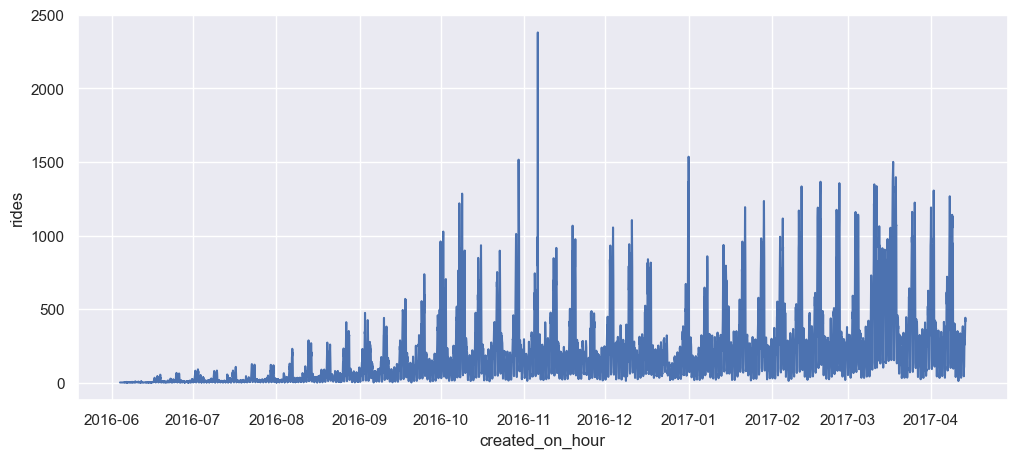

In [5]:
sns.set(rc={'figure.figsize':(12,5)})

sns.lineplot(
    data=df_hourly_rides,
    x="created_on_hour", y="rides", 
    markers=True, dashes=False
);

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df_daily_rides = df_hourly_rides.groupby([df_hourly_rides['created_on_hour'].dt.date]).sum()
df_daily_rides = df_daily_rides.reset_index().rename({"created_on_hour":"created_on_day"})

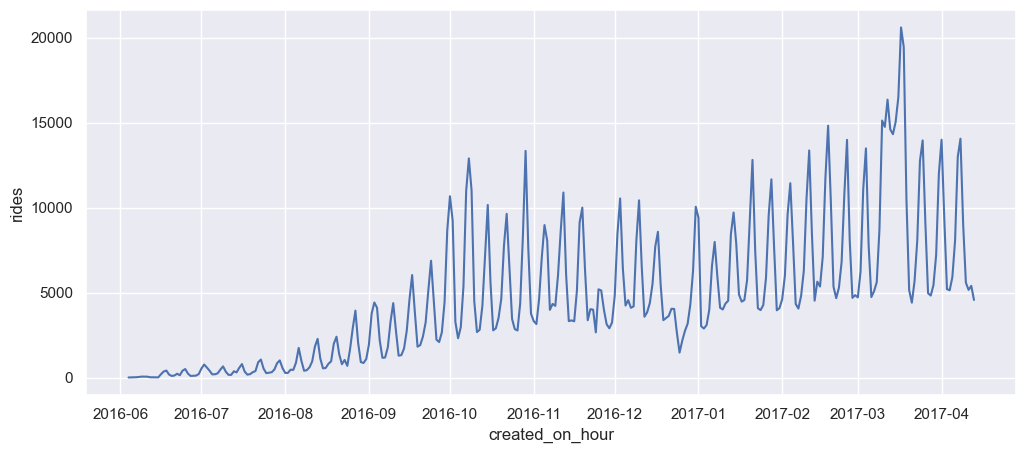

In [8]:
sns.set(rc={'figure.figsize':(12,5)})

sns.lineplot(
    data=df_daily_rides,
    x="created_on_hour", y="rides", 
    markers=True, dashes=False
);

In [9]:
# # Yes its look like there is several kinds of trends 
# 1. First the is a clear periodic which shown by amplitudes, as its easy to see within intervals of 1-2
# months most of hight and the widht are similare.

# 2. Seconde, there is also clear trend of increaing usage with the interval of one year, 
# its easy to see that by following along the line of the moving average 


### Task #2

Plot a ride distance histogram.
What is the distribution? is it normal?

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt 

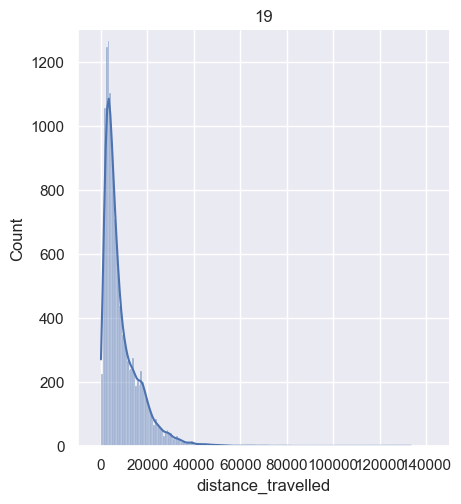

In [12]:
per_of_sample = 0.01
n_sampels  = int(df_rides.shape[0] * per_of_sample)

for i in range(20):
    df_sampled = df_rides.distance_travelled.sample(n= n_sampels)
    sns.displot(df_sampled, kde=True, )
    plt.title(str(i) )
    plt.ylim([0, 1300])
    plt.xlim([-10000, 150000])
    plt.show()
    clear_output(wait=True)

In [13]:
the istogram doesnt looks normal, no normal distribution properties (simetry, mead == median)
Lets test this question using kolmogorov smirnof test
Write a latex lines of hypothesis test 




SyntaxError: invalid syntax (1845462460.py, line 1)

In [21]:
df_rides.distance_travelled.isna().sum()

2

In [19]:
import scipy

scipy.stats.kstest(df_rides.distance_travelled,
                   scipy.stats.norm.cdf)

KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=-1)

## Preprocessing

In [35]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


### Task #3

You have time features in the df_times dataframe. 
Merge this dataframe with the hourly rides dataframe, so you can use those features later.

In [41]:
len(df_times.datetime.unique())

7531

In [38]:
len(df_hourly_rides.created_on_hour.unique())

7296

In [44]:
df_hourly_rides.created_on_hour.isin(df_times.datetime).sum()

7296

In [56]:
df_times[~df_times.datetime.isin(df_hourly_rides.created_on_hour)].datetime.dt.to_period('M').value_counts()

2016-06    202
2016-07     24
2016-08      7
2016-09      1
2017-03      1
Freq: M, Name: datetime, dtype: int64

As it easy to see from the above, the `df_time` object contain all time points that exist in `df_hourly_rides` and more.

in addition the time points that exit in `df_time` and not in `df_hourly_rides` are distributed across months but most of theses measing points related to the "Start" of the data.

So lets left join the `df_hourly_rides` to `df_time`.

In [74]:
# Before joining, lets make sure there is no duplicates in `df_times` 
# (no need for same test in df_hourly_rides, cause we created it)
df_times.datetime.duplicated().sum()

0

In [77]:
df_hourly_times_rides = pd.merge(df_times, 
                                 df_hourly_rides, 
                                 left_on='datetime', 
                                 right_on='created_on_hour',
                                 how="left")

df_hourly_times_rides.shape

(7531, 12)

### Task #4

We would like to add a lag feature, which retrieves the amount of rides taken at the same exact hour last week. 
Please implement this feature.
What is the correlation between current and last week's rides?

In [128]:
hourly_times_rides_last_week = pd.concat([ df_hourly_times_rides[['datetime']] + pd.Timedelta(days=7),
                                           df_hourly_times_rides[['rides']] ], 
                                           axis = 1
                                        )
hourly_times_rides_last_week.rename(columns  = {"rides":"rides_last_week",
                                                "datetime":"datetime_last_week"}, inplace = True)

In [113]:
df_hourly_times_rides = pd.merge(df_hourly_times_rides, 
                                 hourly_times_rides_last_week, 
                                 left_on='datetime', 
                                 right_on='datetime_last_week',
                                 how="left")

## Model

In [140]:
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'sklearn'

### Task #5

We would like to predict how many rides will occur every hour.

As a first step, propose a simple baseline and measure its MAE (mean absolute error)

In [ ]:
train = 
test = df[(df.datetime >= '2017-03-30 00:00:00') & (df.datetime < '2017-04-13 00:00:00')]

### Task #6

Now let's create a model and calculate its performance.

Is it better than the baseline?

**Use the same test set from previous task**.

In [ ]:
y = ''
X = []

X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

### Task #7

You've been offered to purchase an extension of this historical dataset going further into the past. In order to decide whether it is worthwhile, you need to estimate if there's a potential to improve the model given this data.

What is your estimation and why?